# Paper histograms

In [1]:
from coffea import util
from coffea import hist
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.image as mpimg

In [2]:
p_types = ["eplus", "gamma", "piplus"]
p_paths = ["/home/akajal/DiVAE/outputs/2021-09-27/14-49-39/wandb/run-20210927_144940-2k3nuqlz",
           "/home/akajal/DiVAE/outputs/2021-09-27/14-53-09/wandb/run-20210927_145310-3jpbbqcd",
           "/home/akajal/DiVAE/outputs/2021-09-27/14-56-36/wandb/run-20210927_145637-1zsvicv9"]

In [3]:
_COLOR_DICT = {"eplus":"c", "gamma":"m", "piplus":"y"}

In [4]:
_HISTOGRAMS = ["totalEnergyHist", "layer_0_EnergyHist", "layer_1_EnergyHist", "layer_2_EnergyHist",
               "layer_0_sparsityHist", "layer_1_sparsityHist", "layer_2_sparsityHist",
               "layer_0_fracEnergyHist", "layer_1_fracEnergyHist", "layer_2_fracEnergyHist",
               "showerDepthHist", "sampleEnergyHist", "dwTotalEnergyHist"]

_SCALES = ["linear"]

In [16]:
def plot_hist(ax, p_types, p_paths, h_type, yscale, xscale="linear", legend_loc=None, legend_col=2):
    hist_dict = {}
    for p_type, p_path in zip(p_types, p_paths):
        hist_dict[p_type] = util.load(os.path.join(p_path, "files/{0}_{1}.coffea".format(p_type, h_type)))
    
    for p_type in p_types:
        single_hist = hist_dict[p_type]
        
        if "layer" in h_type:
            layerhist = True
            layer = int(h_type[6:7])
            plot_single_hist(single_hist, xscale, ax, p_type, layerhist=True, layernum=layer)
        else:
            plot_single_hist(single_hist, xscale, ax, p_type)
    
    ax.legend(prop={'size': 50}, loc=legend_loc, ncol=legend_col, framealpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=60)
    
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)

In [17]:
def plot_single_hist(c_hist, xscale, ax, p_type, layerhist=False, layernum=-1):
        """
        Args:
            c_hist - coffea hist object
            xscale - xscale of the histogram (log, linear, ...)
            ax - Axes object to plot on
        Returns:
            image - PIL image object
        """
        assert len(c_hist.axes()) == 2, "Histogram should only have two axes - Dataset type and Bins"
        ax_0, ax_1 = c_hist.axes()[0], c_hist.axes()[1]
        
        if isinstance(ax_0, hist.Cat) and isinstance(ax_1, hist.Bin):
            cat_ax = ax_0
            bin_ax = ax_1
        elif isinstance(ax_0, hist.Bin) and isinstance(ax_0, hist.Cat):
            bin_ax = ax_0
            cat_ax = ax_1
        else:
            raise ValueError("Expected categorical and bin axis")
        
        cat_names = [identifier.name for identifier in cat_ax.identifiers()]
        bins = [ax_bin.mid for ax_bin in bin_ax.identifiers()]
        
        value_dict = {cat_name:c_hist.values(overflow='all')[(cat_name,)] for cat_name in cat_names}
        if xscale == "log":
            hi_bins = [ax_bin.hi for ax_bin in bin_ax.identifiers()]
            lo_bins = [ax_bin.lo for ax_bin in bin_ax.identifiers()]
            diff_bins = [hi_bin - lo_bin for hi_bin, lo_bin in zip(hi_bins, lo_bins)]
            
            for cat_name in cat_names:
                values = value_dict[cat_name]
                values[1:len(values)-1] = values[1:len(values)-1]/np.array(diff_bins)
                value_dict[cat_name] = values
              
        bins = [bins[0]] + bins + [bins[len(bins)-1]]
        
        for cat_name in cat_names:
            if cat_name == "input" or cat_name == "samples" or cat_name == "true":
                if p_type == "eplus":
                    p_label = r"""$e^{+}$"""
                elif p_type == "gamma":
                    p_label = r"""$\gamma$  """
                else:
                    p_label = r"""$\pi^{+}$"""   
                if cat_name == "input":
                    ax.fill_between(bins, value_dict[cat_name], label=p_label + " " + "GEANT", color=_COLOR_DICT[p_type], step="mid", alpha=0.4)
                else:
                    ax.step(bins, value_dict[cat_name], label=p_label + " " + "DVAE", where="mid", color=_COLOR_DICT[p_type], linewidth=4.0)
            
        if layerhist:
            xlabel = "Layer " + str(layernum) + " {0}".format(bin_ax.label)
        else:
            xlabel = bin_ax.label
            
        ax.set_xlabel(xlabel, fontsize='60')
        
        if xscale == "log":
            ax.set_ylabel(c_hist.label + " / Bin Width", fontsize='60')
        else:
            ax.set_ylabel(c_hist.label, fontsize='60')
        
        return

In [18]:
def plot_all_hists(savefig=False, show=True):
    fig, axs = plt.subplots(3, 3, figsize=(90, 70))
    
    # Plot the histograms
    plot_hist(axs[0, 0], p_types, p_paths, "layer_0_fracEnergyHist", "log", xscale="log", legend_loc="upper right")
    plot_hist(axs[0, 1], p_types, p_paths, "layer_1_fracEnergyHist", "log", xscale="log", legend_loc="upper center")
    plot_hist(axs[0, 2], p_types, p_paths, "layer_2_fracEnergyHist", "log", xscale="log", legend_loc="upper right")
    
    plot_hist(axs[1, 0], p_types, p_paths, "layer_0_sparsityHist", "log", legend_loc="upper right")
    plot_hist(axs[1, 1], p_types, p_paths, "layer_1_sparsityHist", "log", legend_loc="upper center")
    plot_hist(axs[1, 2], p_types, p_paths, "layer_2_sparsityHist", "log", legend_loc="upper right")
    
    plot_hist(axs[2, 0], p_types, p_paths, "totalEnergyHist", "log", legend_loc="upper right")
    plot_hist(axs[2, 1], p_types, p_paths, "dwTotalEnergyHist", "log", xscale="log", legend_loc="upper right")
    plot_hist(axs[2, 2], p_types, p_paths, "showerDepthHist", "log", legend_loc="upper right")
    
    if savefig:
        plt.savefig(os.path.join(os.getcwd(), "svg/all_hists.svg"), dpi=100)
    if show:
        plt.show()
    plt.close()

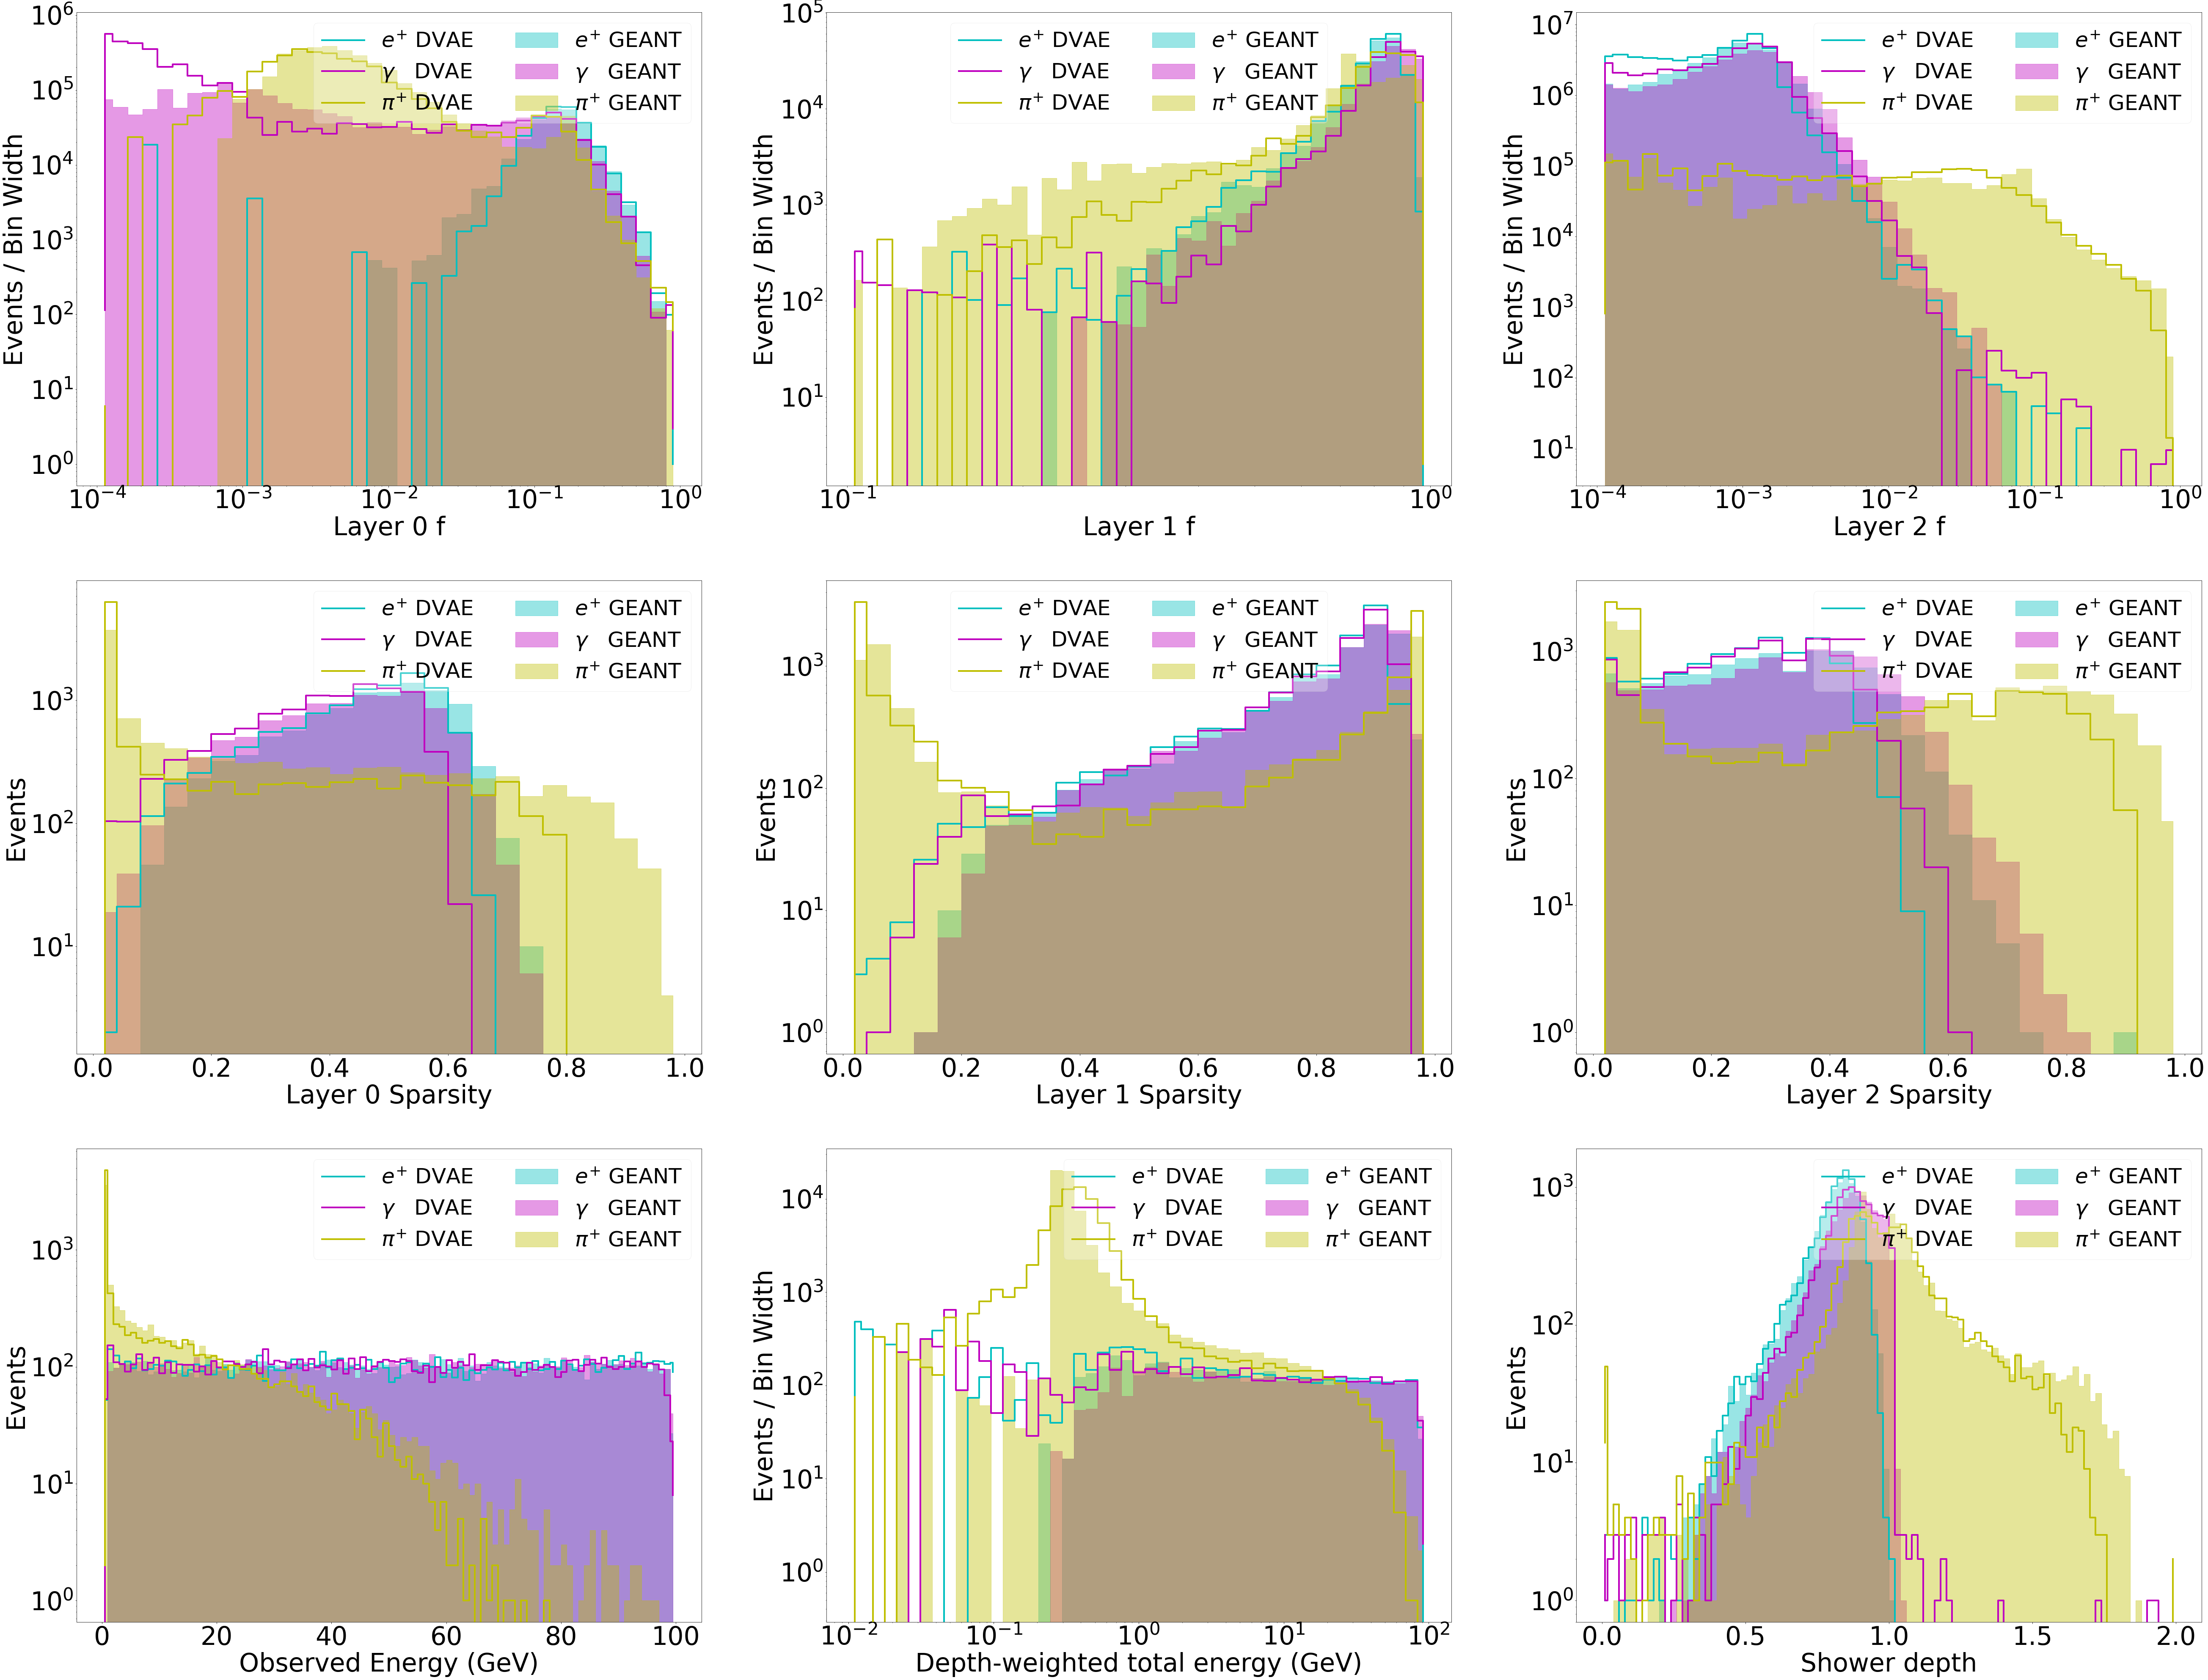

In [19]:
plot_all_hists(savefig=True)

In [223]:
def plot_sample_hist(p_types, p_paths, h_type, yscale, xscale="linear", legend_loc=None, legend_col=1, savefig=False, show=True):
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    
    hist_dict = {}
    for p_type, p_path in zip(p_types, p_paths):
        hist_dict[p_type] = util.load(os.path.join(p_path, "files/{0}_{1}.coffea".format(p_type, h_type)))
    
    for p_type in p_types:
        single_hist = hist_dict[p_type]
        
        if "layer" in h_type:
            layerhist = True
            layer = int(h_type[6:7])
            plot_single_hist(single_hist, xscale, ax, p_type, layerhist=True, layernum=layer)
        else:
            plot_single_hist(single_hist, xscale, ax, p_type)
    
    ax.legend(prop={'size': 35}, loc=legend_loc, ncol=legend_col, framealpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=60)
    
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    
    if savefig:
        plt.savefig(os.path.join(os.getcwd(), "paper/svg/sample_hist.svg"), dpi=100)
    if show:
        plt.show()
    plt.close()

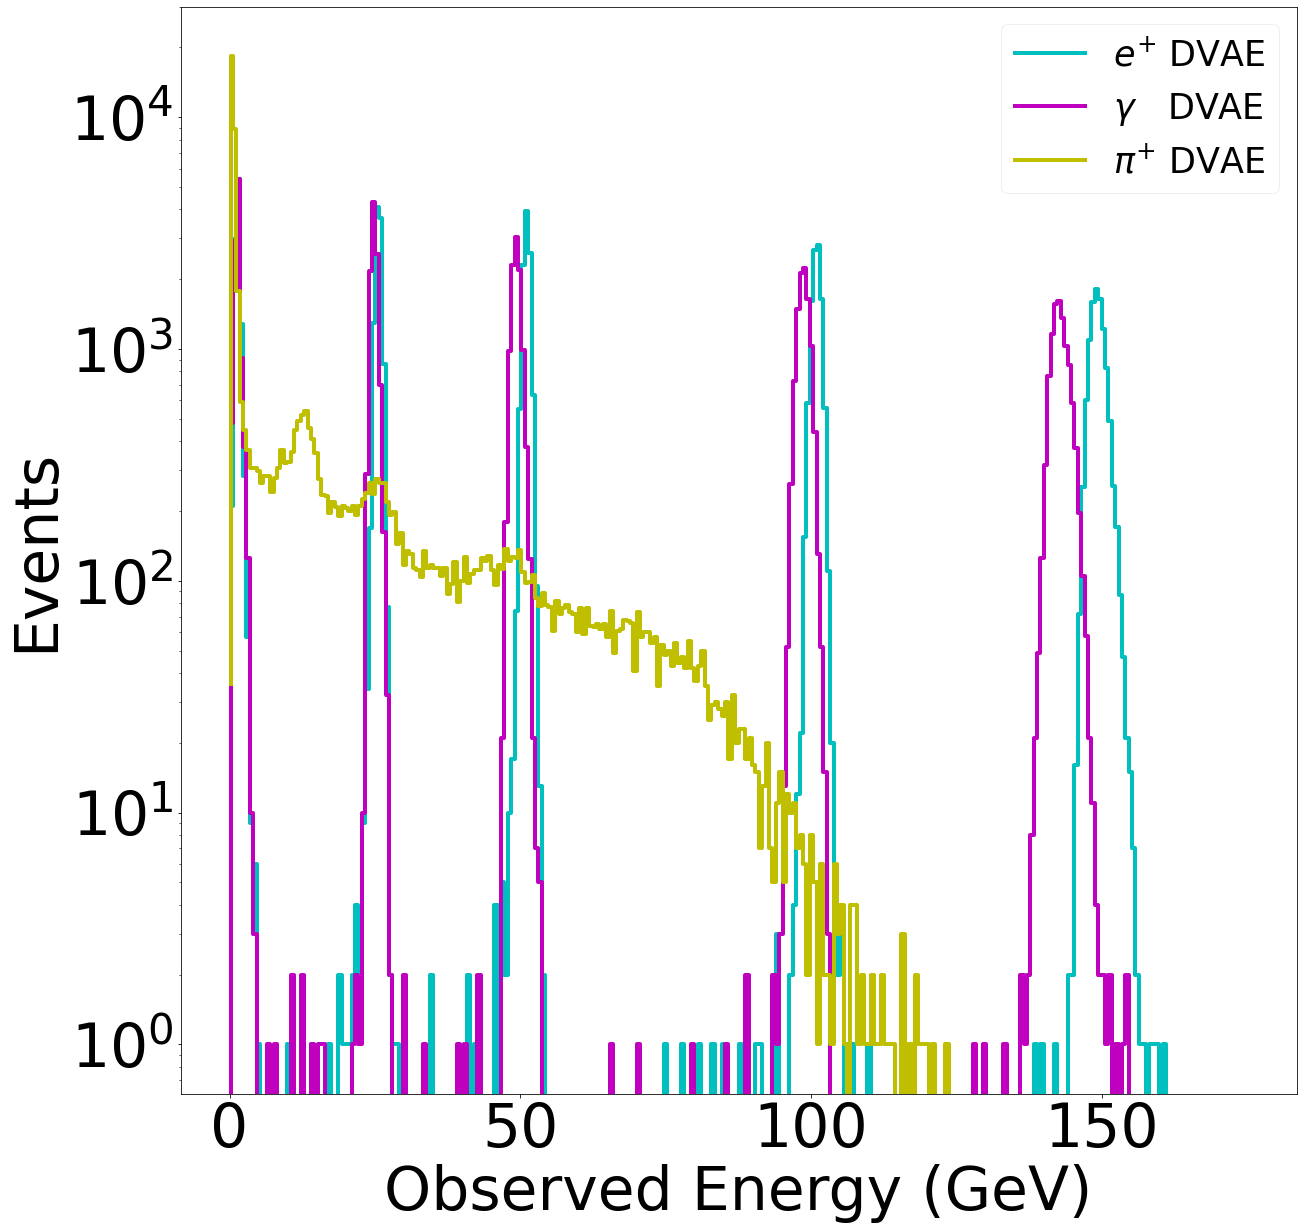

In [224]:
plot_sample_hist(p_types, p_paths, "sampleEnergyHist", "log", legend_loc="upper right", savefig=True)

In [232]:
def plot_shower_images(p_types, p_paths, savefig=False, show=True):
    fig, axs = plt.subplots(3, 4, figsize=(90, 30))
    
    image_dict = {}
    for p_type, p_path in zip(p_types, p_paths):
        row = 0
        for i in range(4):
            image_path = os.path.join(p_path, "files/media/images/val_sample_0_{0}.png".format(i))
            axs[row, i].axis('off')
            axs[row, i].imshow(mpimg.imread(image_path))
        row += 1
            
    if savefig:
        plt.savefig(os.path.join(os.getcwd(), "paper/svg/shower_images.svg"), dpi=100)
    if show:
        plt.show()
    plt.close()

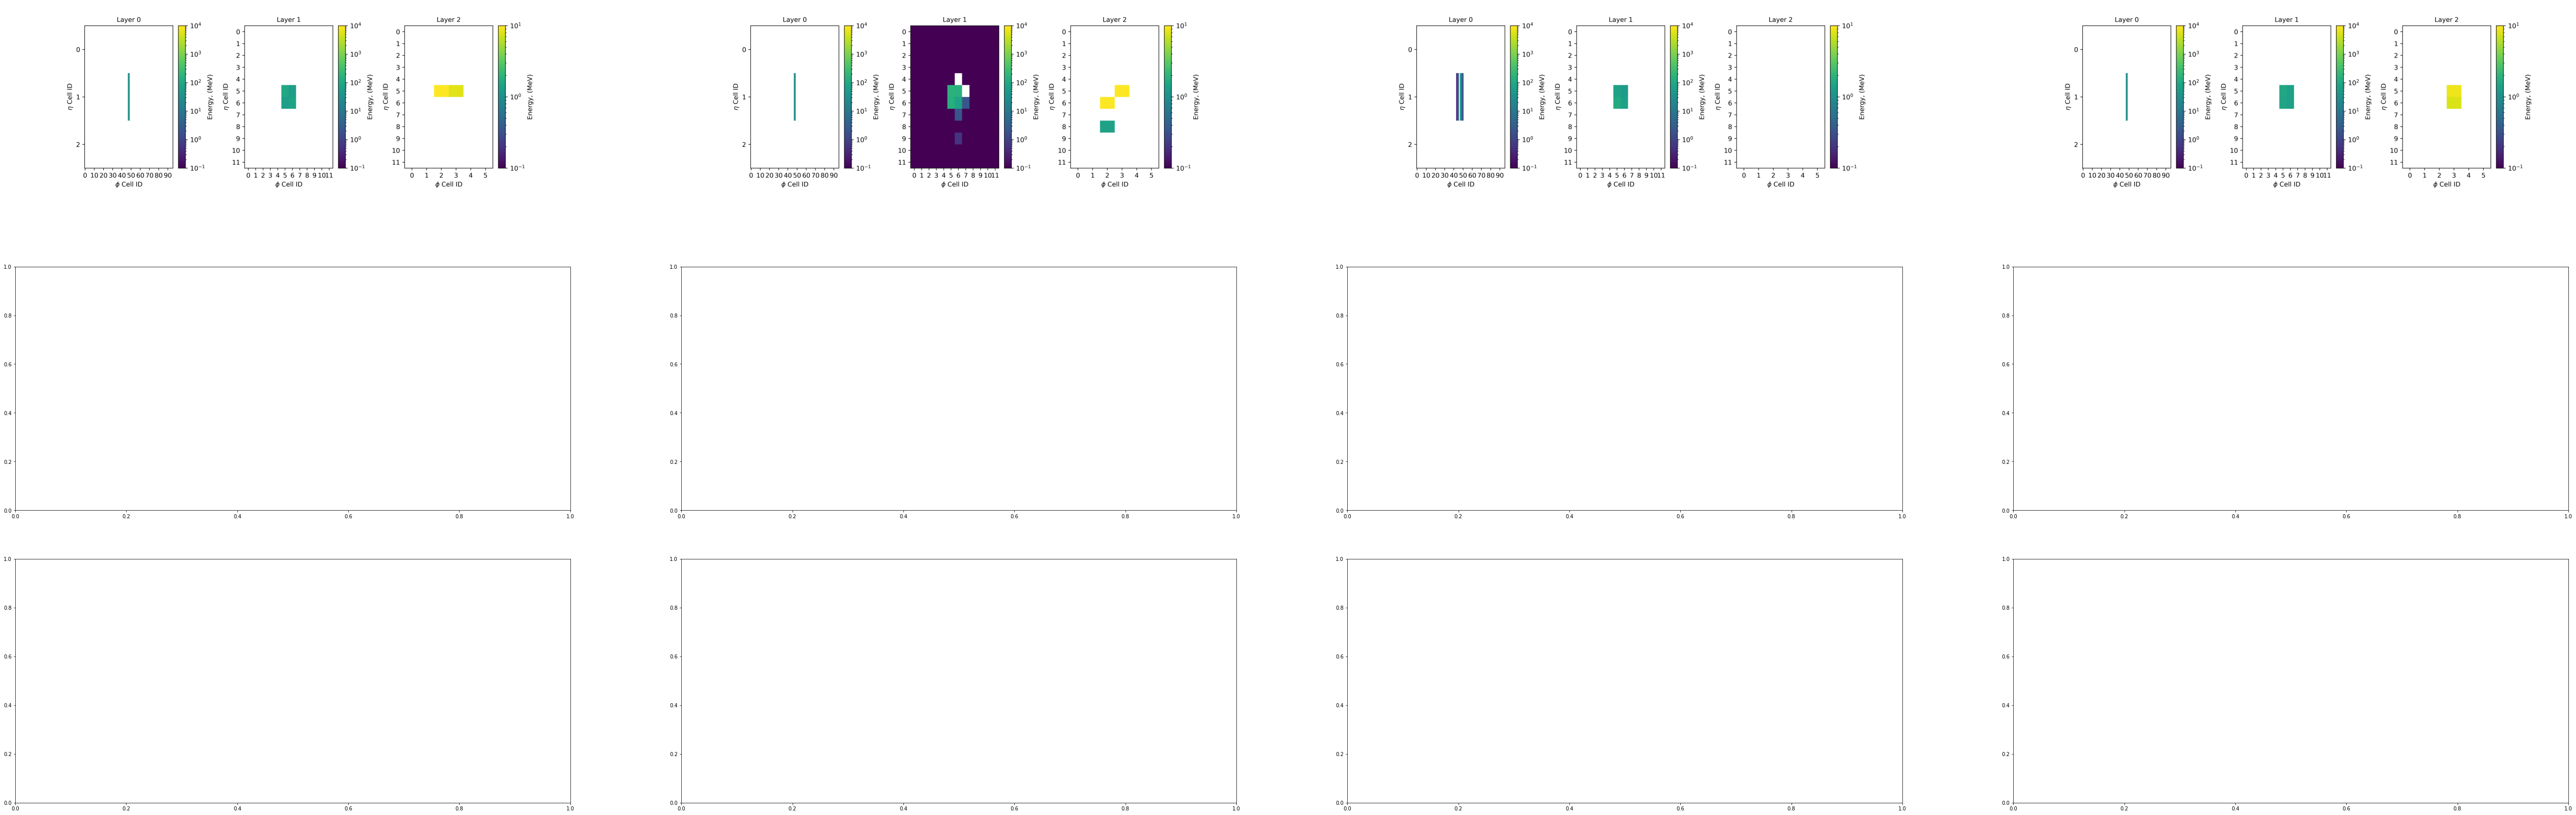

In [233]:
plot_shower_images(p_types, p_paths, savefig=True)